In [1]:
import time
import h5py
import torch
import torch.nn as nn
import torchvision as tv

from torchvision import transforms
from torch.optim import SGD
from torch.utils.data import DataLoader, Dataset

import mlflow

import numpy as np
import matplotlib.pyplot as plt

from craterdetection.detection.model import DeepMoon
from craterdetection.detection.training import F1Loss

In [2]:
mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("crater-detection")

In [3]:
model = DeepMoon()
model.load_state_dict(torch.load("../blobs/DeepMoon.pth"))
model.cuda()
print('Successful')

Successful


In [28]:
class CraterDataset(Dataset):
    transform = {
        'images': transforms.Compose([
            transforms.ToTensor()
        ]),
        'masks': transforms.Compose([
            transforms.ToTensor()
        ])
    }
    def __init__(self,
                 file_path,
                 group,
                 cuda=True
                 ):
        self.file_path = file_path
        self.group = group
        self.dataset = None
        self.cuda = cuda

    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.file_path, 'r')

        images = torch.tensor(self.dataset[self.group]["images"][idx])
        masks = torch.tensor(self.dataset[self.group]["masks"][idx])

        if self.cuda:
            return images.cuda(), masks.cuda()
        else:
            return images, masks

    def random(self):
        return self.__getitem__(
            np.random.randint(0, len(self))
        )

    def __len__(self):
        with h5py.File(self.file_path, 'r') as f:
            return len(f[self.group]['images'])

    def __del__(self):
        if self.dataset is not None:
            self.dataset.close()

train_dataset = CraterDataset("../data/dataset.h5", "training")
train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)

validation_dataset = CraterDataset("../data/dataset.h5", "validation")
validation_dataloader = DataLoader(train_dataset, batch_size=12, num_workers=0)

test_dataset = CraterDataset("../data/dataset.h5", "test")
test_dataloader = DataLoader(train_dataset, batch_size=12, num_workers=0)

In [29]:
loss_function = nn.BCELoss().cuda()

learning_rate = 1e-3
momentum = 0.9

optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [35]:
num_epochs = 3
with mlflow.start_run():
    for e in range(1, num_epochs+1):
        print(f'\n-----Epoch {e} started.-----\n')
        mlflow.log_param('learning-rate', learning_rate)
        mlflow.log_param('momentum', momentum)

        since = time.time()

        train_losses, val_losses = [], []

        model.train()
        for batch, (images, masks) in enumerate(train_dataloader, 1):

            optimizer.zero_grad()
            pred = model(images)

            loss = loss_function(pred, masks)
            loss.backward()
            train_losses.append(loss.item())

            optimizer.step()

            if batch % 20 == 0 or batch == 1 or batch==len(train_dataloader):
                time_elapsed = time.time() - since
                print(
                    f'Training loss = {np.average(train_losses):8.3f} | ',
                    f'Batch # {batch:6.0f} | [{time_elapsed//60:3.0f}m {time_elapsed%60:2.0f}s]'
                )
                mlflow.log_metric('train_loss', np.average(train_losses), step=e*batch)



        time_elapsed = time.time() - since
        print(
            f"\nSummary:\n",
            f"\tEpoch: {e}/{num_epochs}\n",
            f"\tLearning Rate: {learning_rate}\n",
            f"\tDuration: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s"
        )

        print(f'-----Epoch {e} finished.-----\n')


-----Epoch 1 started.-----

Training loss =    0.195 |  Batch #      1 | [  0m  0s]
Training loss =    0.178 |  Batch #     20 | [  0m  9s]
Training loss =    0.178 |  Batch #     40 | [  0m 18s]
Training loss =    0.176 |  Batch #     60 | [  0m 28s]
Training loss =    0.179 |  Batch #     80 | [  0m 37s]
Training loss =    0.180 |  Batch #    100 | [  0m 46s]
Training loss =    0.178 |  Batch #    120 | [  0m 55s]
Training loss =    0.176 |  Batch #    140 | [  1m  5s]
Training loss =    0.177 |  Batch #    160 | [  1m 14s]
Training loss =    0.177 |  Batch #    180 | [  1m 23s]
Training loss =    0.177 |  Batch #    200 | [  1m 32s]
Training loss =    0.178 |  Batch #    220 | [  1m 42s]
Training loss =    0.178 |  Batch #    240 | [  1m 51s]
Training loss =    0.177 |  Batch #    260 | [  2m  0s]
Training loss =    0.177 |  Batch #    280 | [  2m  9s]
Training loss =    0.177 |  Batch #    300 | [  2m 19s]
Training loss =    0.178 |  Batch #    320 | [  2m 28s]
Training loss =    

KeyboardInterrupt: 

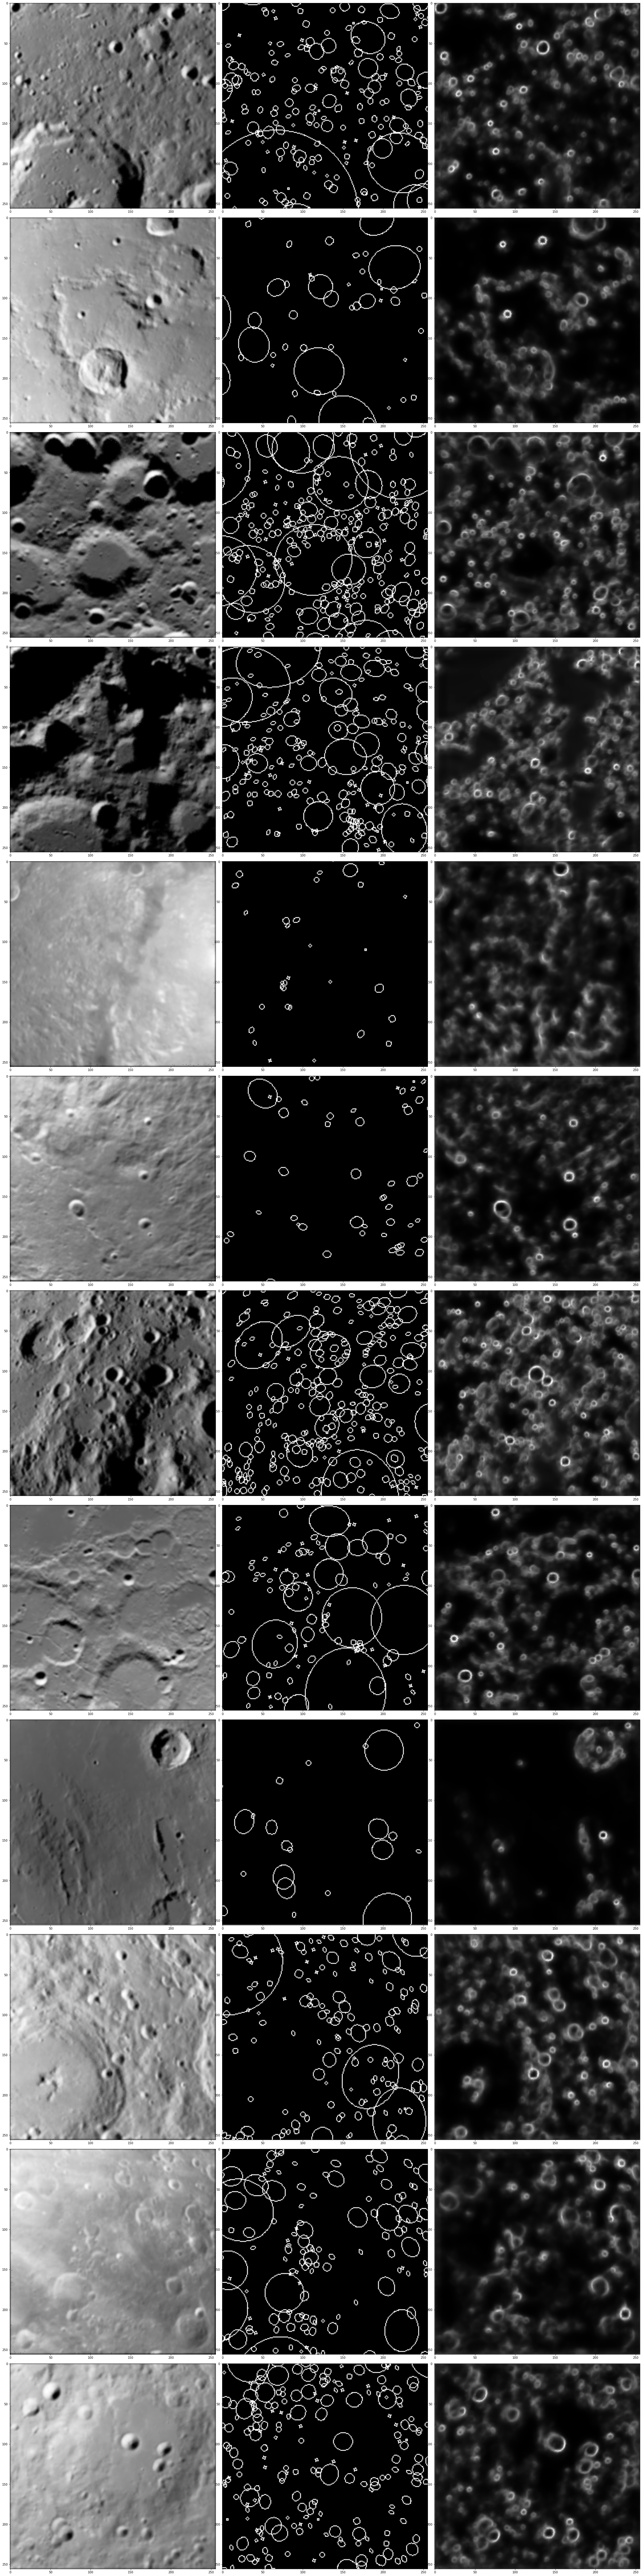

In [36]:
images, masks = next(iter(test_dataloader))
model.eval()
with torch.no_grad():
    out = model(images)

fig, axes = plt.subplots(12, 3, figsize=(30, 120))

for i in range(12):
    axes[i, 0].imshow(images[i, 0].cpu().numpy(), cmap='Greys_r')
    axes[i, 1].imshow(masks[i, 0].cpu().numpy(), cmap='Greys_r')
    axes[i, 2].imshow(out[i, 0].cpu().numpy(), cmap='Greys_r')
fig.tight_layout()

In [9]:
model.eval()
score = 0
with torch.no_grad():
    for images, masks in test_dataloader:
        pred = model(images)

In [14]:
with mlflow.start_run(run_id="248212ce8c514f54a4485423cb113c69"):
    mlflow.pytorch.log_model(model, "model")